Import Library

In [ ]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  


In [3]:
base_dir = os.path.abspath(os.getcwd()) + os.path.join("\\Data\\Breast-Cancer-Ultrasound")

os.listdir(base_dir)

['original', 'train', 'val']

In [4]:
train_dir = os.path.join(base_dir, "train")    

os.listdir(train_dir)

['benign', 'malignant', 'normal']

In [5]:
validation_dir = os.path.join(base_dir, "val")    

os.listdir(validation_dir)

['benign', 'malignant', 'normal']

In [6]:
original_dir = os.path.join(base_dir, "original")    

os.listdir(original_dir)

['benign', 'malignant', 'normal']

In [ ]:
import random
import shutil

train_ratio = 0.8

if os.listdir(train_dir, os.path.join("Benign")) is 0:
    # Loop untuk tiap kelas
    for class_name in ['benign', 'malignant', 'normal']:
        class_path = os.path.join(original_dir, class_name)
        images = os.listdir(class_path)
        random.shuffle(images)
        
        # Hitung jumlah data latih dan uji
        train_size = int(len(images) * train_ratio)
        train_images = images[:train_size]
        test_images = images[train_size:]
        
        # Buat subfolder jika belum ada
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
        
        # Pindahkan gambar ke folder train dan test
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(validation_dir, class_name, img))

    print("Pembagian data selesai.")


Pembagian data selesai.


In [16]:
# Menambahkan fungsi random_contrast pada train_datagen dan val_datagen
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=30,
                horizontal_flip=True,
                shear_range=0.1,
                zoom_range=0.1,
                fill_mode='nearest',
                validation_split=0.2
)

val_datagen = ImageDataGenerator(
                rescale=1./255,
                validation_split=0.2
)


In [17]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data latih
        target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4,
        shuffle=True,
        # karena ini merupakan masalah klasifikasi 2 kelas, gunakan class_mode = 'binary'
        class_mode='categorical')
 
validation_generator = val_datagen.flow_from_directory(
        validation_dir, # direktori data validasi
        target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=32, # karena ini merupakan masalah klasifikasi 2 kelas gunakan class_mode = 'binary'
        shuffle=False,
        class_mode='categorical')

Found 1260 images belonging to 3 classes.
Found 318 images belonging to 3 classes.


Malignant Images:


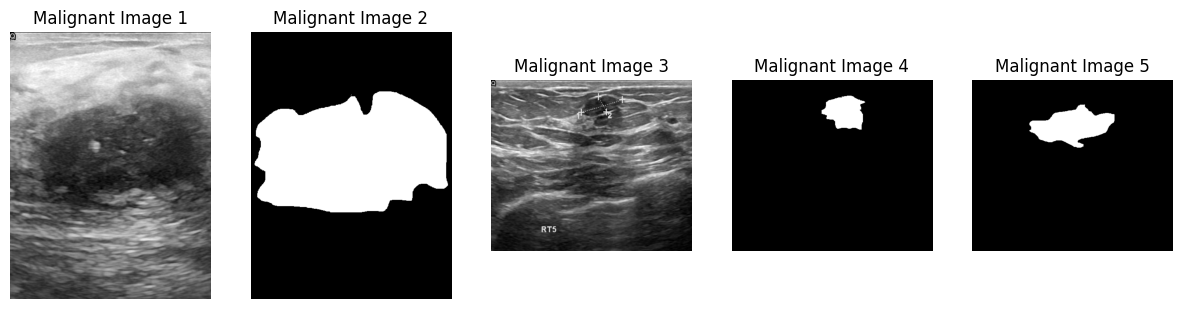

Benign Images:


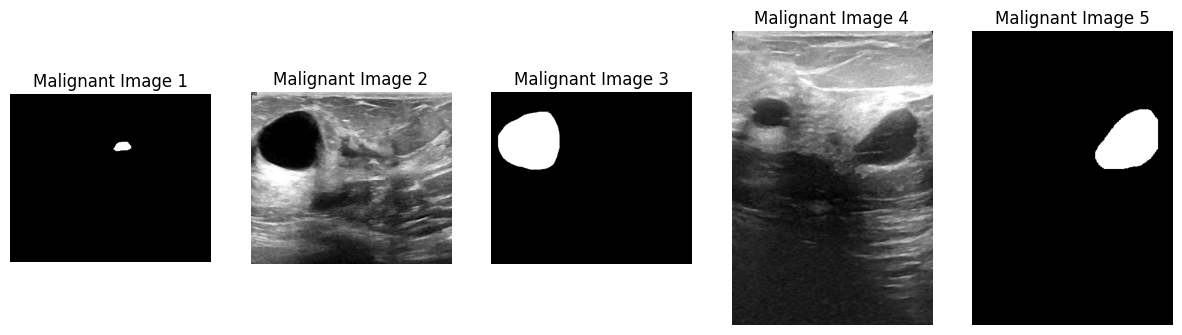

Normal Images:


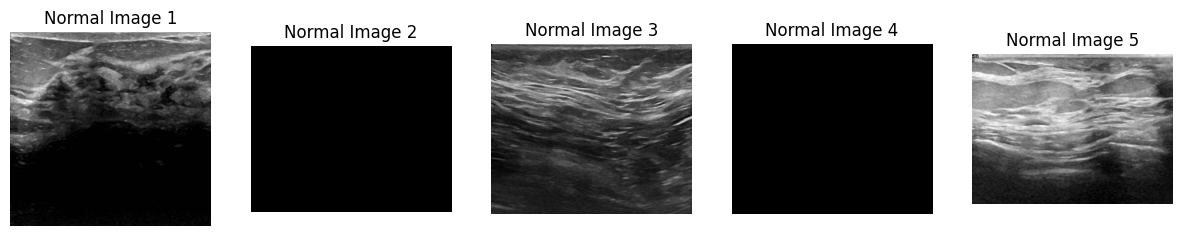

In [18]:
from PIL import Image

def display_images_from_folder(folder_path, folder_name):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    
    # Display the first 5 images
    plt.figure(figsize=(15, 5))
    for i, img_file in enumerate(image_files[:5]):
        img_path = os.path.join(folder_path, img_file)
        img = Image.open(img_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{folder_name} Image {i+1}")
        plt.axis('off')
    plt.show()

print("Malignant Images:")
display_images_from_folder(os.path.join(train_dir, "malignant"), "Malignant")

print("Benign Images:")
display_images_from_folder(os.path.join(train_dir, "Benign"), "Malignant")

print("Normal Images:")
display_images_from_folder(os.path.join(train_dir, "normal"), "Normal")

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),  # Sesuaikan ukuran Dense layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')  # Output layer dengan 3 kelas
])

In [20]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 72, 72, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 34, 34, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 15, 15, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,535,299 (24.93 MB)

 Trainable params: 6,535,299 (24.93 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Loss untuk 3 kelas
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_generator,
    epochs=40,                   # jumlah epoch, bisa ditambah sesuai kebutuhan
    validation_data=validation_generator,
    verbose=2
)


Epoch 1/40
315/315 - 33s - 105ms/step - accuracy: 0.5476 - loss: 0.9779 - val_accuracy: 0.5629 - val_loss: 0.8984
Epoch 2/40
315/315 - 28s - 90ms/step - accuracy: 0.5627 - loss: 0.9320 - val_accuracy: 0.5566 - val_loss: 0.8422
Epoch 3/40
315/315 - 28s - 90ms/step - accuracy: 0.5540 - loss: 0.9052 - val_accuracy: 0.5535 - val_loss: 0.8971
Epoch 4/40
315/315 - 29s - 94ms/step - accuracy: 0.5563 - loss: 0.9181 - val_accuracy: 0.5818 - val_loss: 0.8560
Epoch 5/40
315/315 - 29s - 93ms/step - accuracy: 0.5825 - loss: 0.8624 - val_accuracy: 0.4371 - val_loss: 1.0017
Epoch 6/40
315/315 - 29s - 94ms/step - accuracy: 0.6008 - loss: 0.8585 - val_accuracy: 0.5849 - val_loss: 0.7453
Epoch 7/40
315/315 - 28s - 90ms/step - accuracy: 0.6571 - loss: 0.7679 - val_accuracy: 0.6730 - val_loss: 0.6669
Epoch 8/40
315/315 - 28s - 89ms/step - accuracy: 0.6794 - loss: 0.7076 - val_accuracy: 0.7138 - val_loss: 0.5907
Epoch 9/40
315/315 - 28s - 88ms/step - accuracy: 0.7016 - loss: 0.6836 - val_accuracy: 0.7201 -

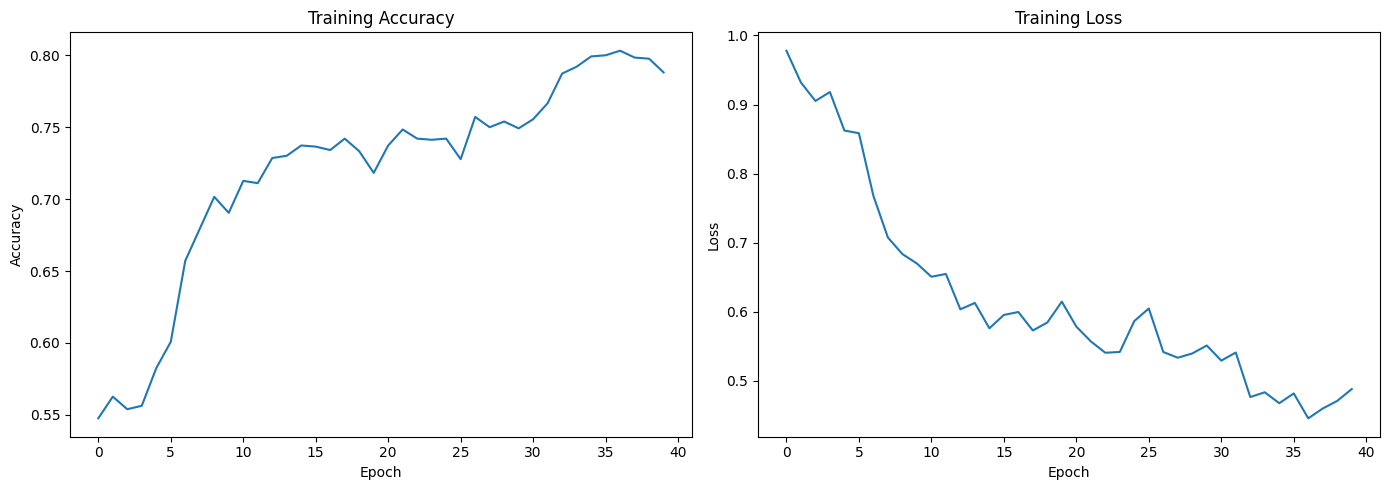

In [23]:
accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(accuracy))

# Convert accuracy and loss to a DataFrame for easier plotting with Seaborn
history_df = pd.DataFrame({
    'Epoch': epochs,
    'Accuracy': accuracy,
    'Loss': loss
})

# Create subplots to place the plots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot training accuracy using Seaborn
sns.lineplot(data=history_df, x='Epoch', y='Accuracy', ax=axes[0])
axes[0].set_title('Training Accuracy')

# Plot training loss using Seaborn
sns.lineplot(data=history_df, x='Epoch', y='Loss', ax=axes[1])
axes[1].set_title('Training Loss')

# Display the plots
plt.tight_layout()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step


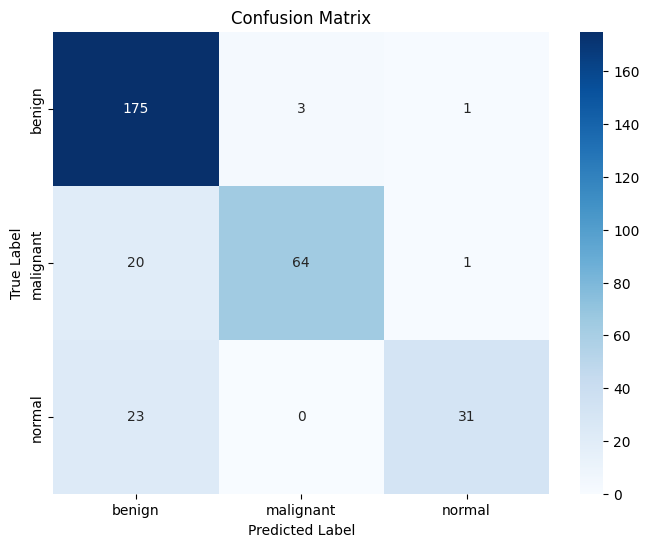

              precision    recall  f1-score   support

      benign       0.80      0.98      0.88       179
   malignant       0.96      0.75      0.84        85
      normal       0.94      0.57      0.71        54

    accuracy                           0.85       318
   macro avg       0.90      0.77      0.81       318
weighted avg       0.87      0.85      0.84       318



In [ ]:

y_true = validation_generator.classes  # Label asli
y_pred_prob = model.predict(validation_generator)  # Prediksi probabilitas
y_pred = np.argmax(y_pred_prob, axis=1)  # Prediksi kelas

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report (akurasinya per kelas, precision, recall, f1-score)
print(classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys()))

In [25]:
model.save("model/breast-cancer-ultrasound.h5")